In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России.

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

- Визуальный анализ ряда
- Стабилизация дисперсии (при необходимости)
- Выбор порядка дифференцирования
- Выбор начальных приближений для p, q, P, Q
- Обучение и сравнение моделей-кандидатов, выбор победителя
- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q
- Прогнозирование с помощью финальной модели.

In [22]:
wage = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [23]:
wage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
WAG_C_M    284 non-null float64
dtypes: float64(1)
memory usage: 4.4 KB


In [24]:
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


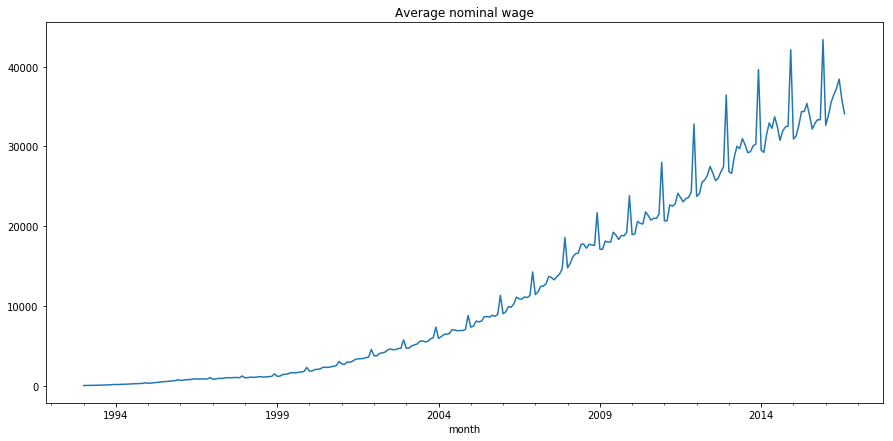

In [25]:
plt.figure(figsize=(15, 7));

wage.WAG_C_M.plot()
plt.title('Average nominal wage')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

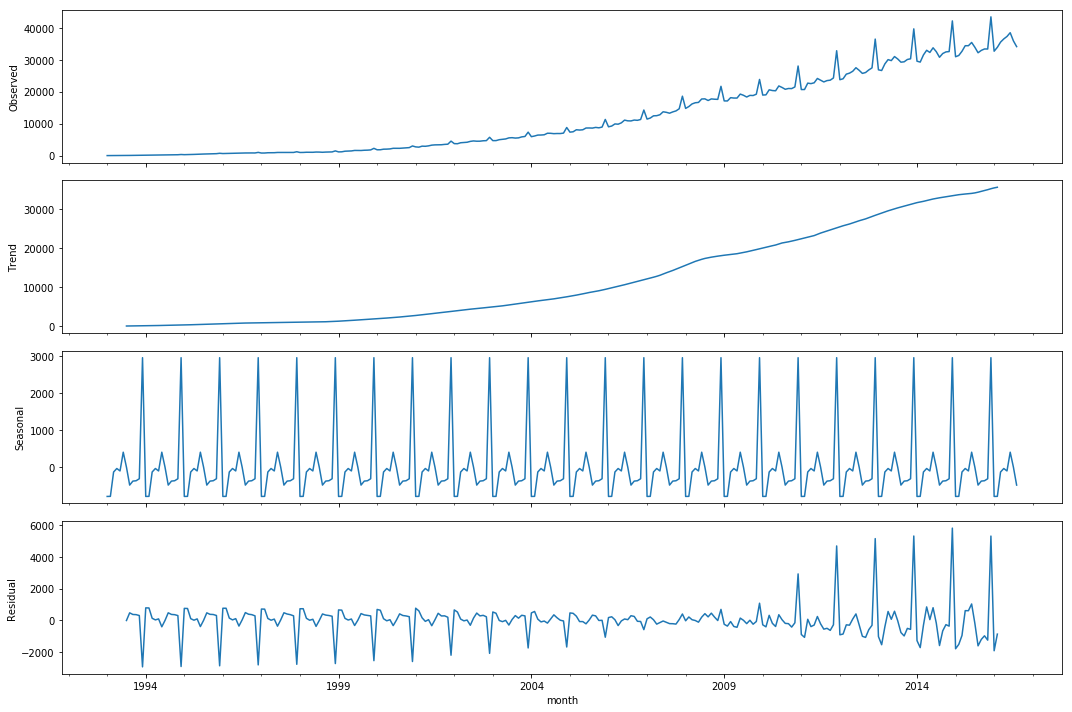

In [26]:
plt.figure(figsize(15,10));
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


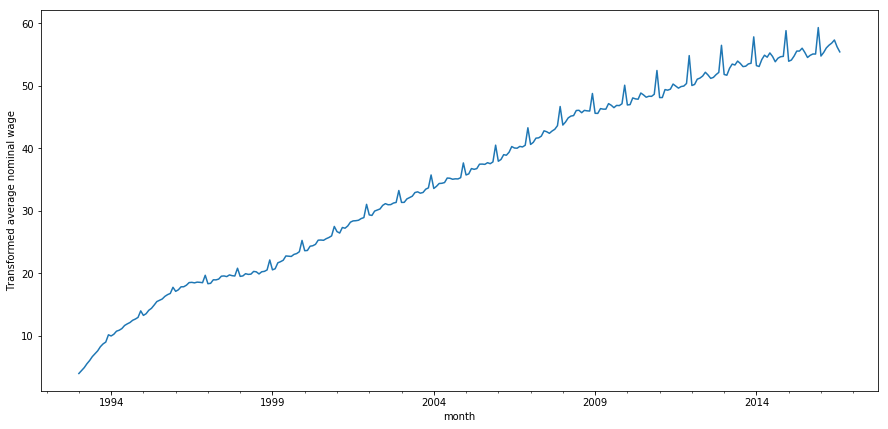

In [28]:
wage['WAG_C_M_box'], lmbda = stats.boxcox(wage.WAG_C_M)

plt.figure(figsize(15,7))
wage.WAG_C_M_box.plot()
plt.ylabel(u'Transformed average nominal wage')

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

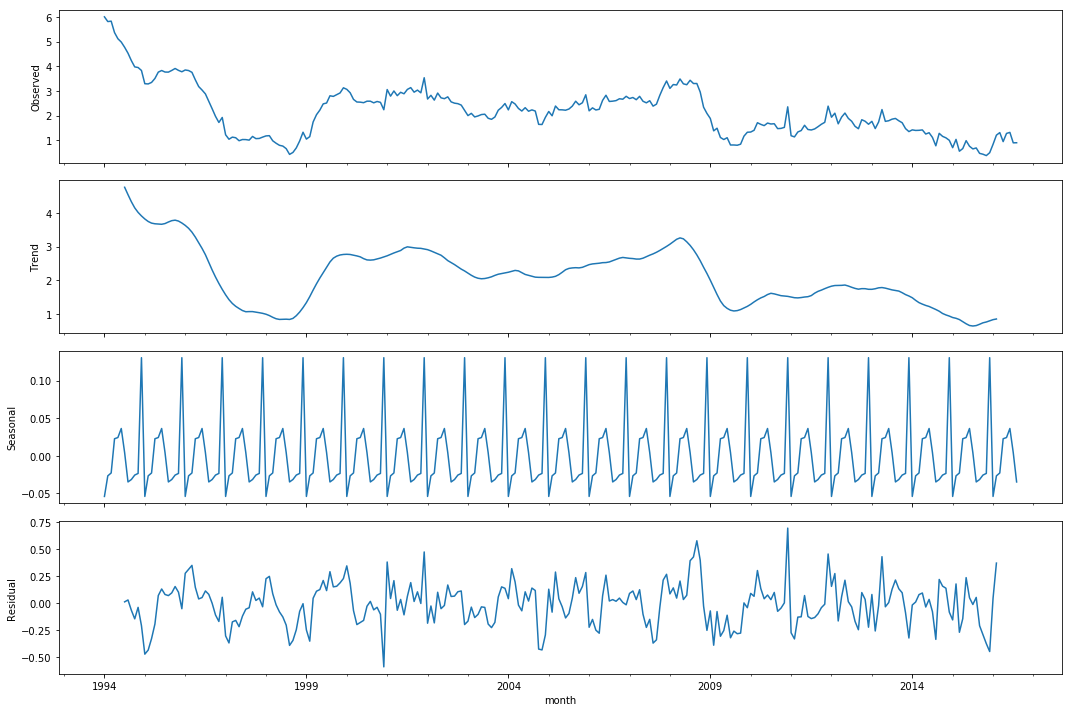

In [29]:
wage['WAG_C_M_box_diff'] = wage.WAG_C_M_box - wage.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M_box_diff.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M_box_diff.dropna())[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, НО полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

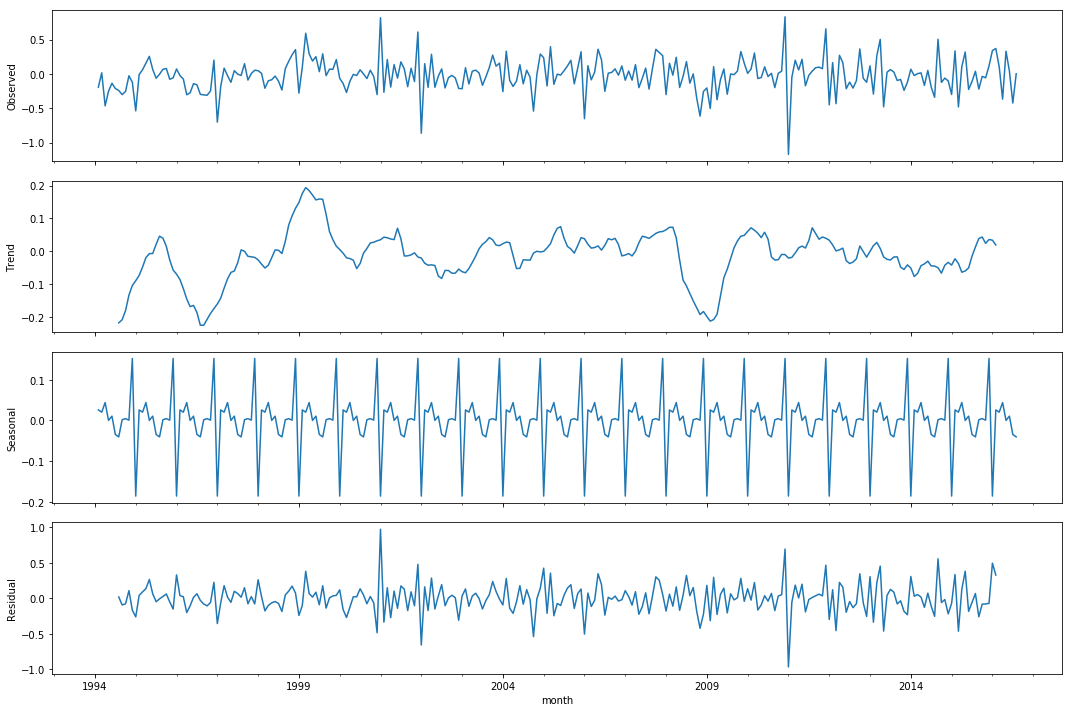

In [30]:
wage['WAG_C_M_box_diff2'] = wage.WAG_C_M_box_diff - wage.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M_box_diff2.dropna()).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M_box_diff2.dropna())[1])

Гипотеза нестационарности отвергается с ещё большим уровнем значимости, и визуально ряд выглядит лучше — тренда больше нет.

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

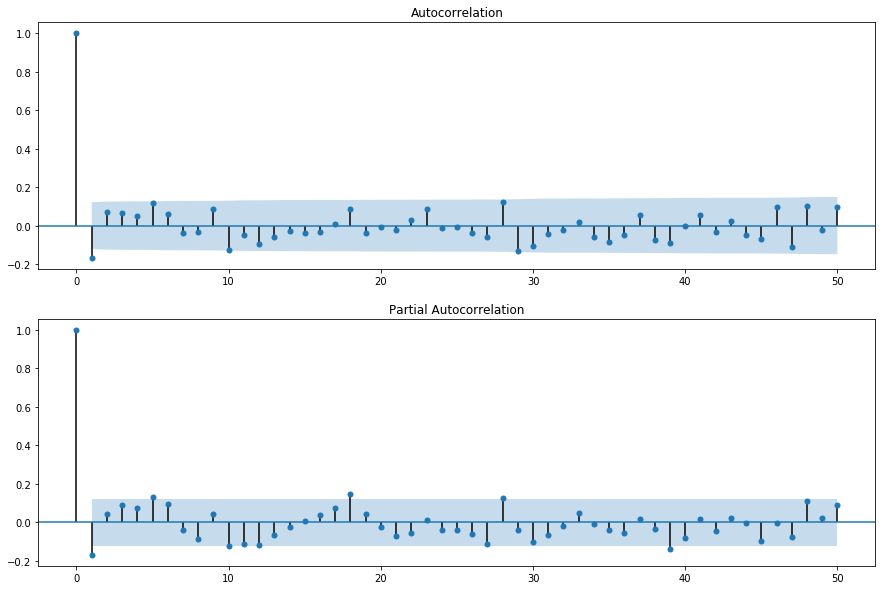

In [32]:
plt.figure(figsize=(15,10))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.WAG_C_M_box_diff2.dropna()[12:].squeeze(), lags=50, ax=ax);

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.WAG_C_M_box_diff2.dropna()[12:].squeeze(), lags=50, ax=ax);

Начальные приближения: Q=0, q=1, P=1, p=1.

In [34]:
ps = range(0, 2)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

In [38]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
parameters_list

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0)]

In [39]:
len(parameters_list)

8

In [42]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 2.14 s


In [44]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
4  (1, 0, 1, 0)  0.340521
2  (0, 1, 1, 0)  1.170768
6  (1, 1, 1, 0)  2.021911
3  (1, 0, 0, 0)  2.625709
1  (0, 1, 0, 0)  3.369832


In [45]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Mon, 14 Jan 2019   AIC                              0.341
Time:                                    11:16:41   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

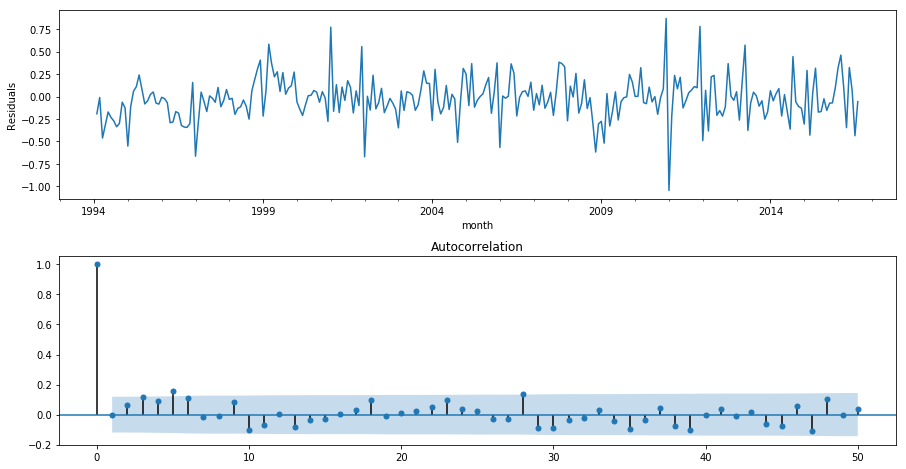

Критерий Стьюдента: p=0.090789
Критерий Дики-Фуллера: p=0.000003


In [47]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

plt.subplots_adjust(hspace = 0.3)
plt.show()

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

In [48]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

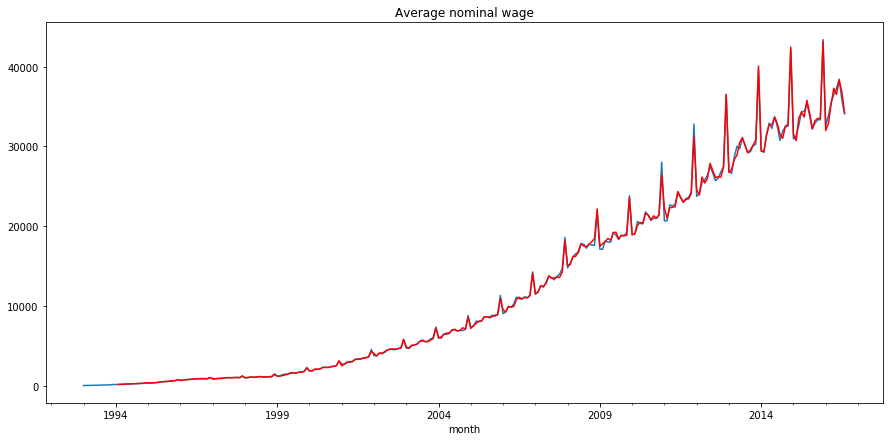

In [50]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15,7));
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.title('Average nominal wage');

### Прогноз

In [55]:
wage.tail()

,WAG_C_M,WAG_C_M_box,WAG_C_M_box_diff,WAG_C_M_box_diff2,model
month,,,,,
2016-04-01,36497.0,56.526742,0.942729,-0.366210,37298.895012
2016-05-01,37270.0,56.860441,1.275065,0.332336,36523.754084
2016-06-01,38447.0,57.358885,1.316994,0.041929,38284.633568
2016-07-01,35888.0,56.260153,0.893671,-0.423323,36887.642151
2016-08-01,34095.0,55.455409,0.896620,0.002949,34219.816724


In [68]:
len(wage)

284

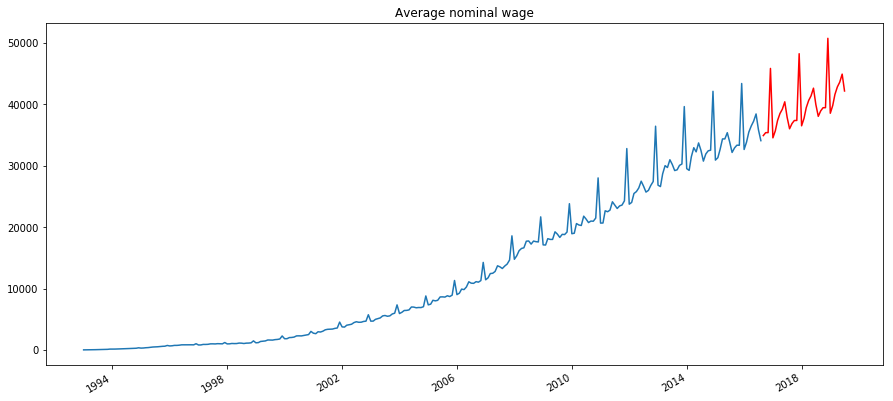

In [69]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=350), lmbda)

plt.figure(figsize=(15,7));
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.title('Average nominal wage');